In [1]:
# Get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

ModuleNotFoundError: No module named 'fastai'

In [ ]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [6]:
PATH = "../../data/food-101/"

In [5]:
sz=224

In [21]:
# util to plot imgs
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

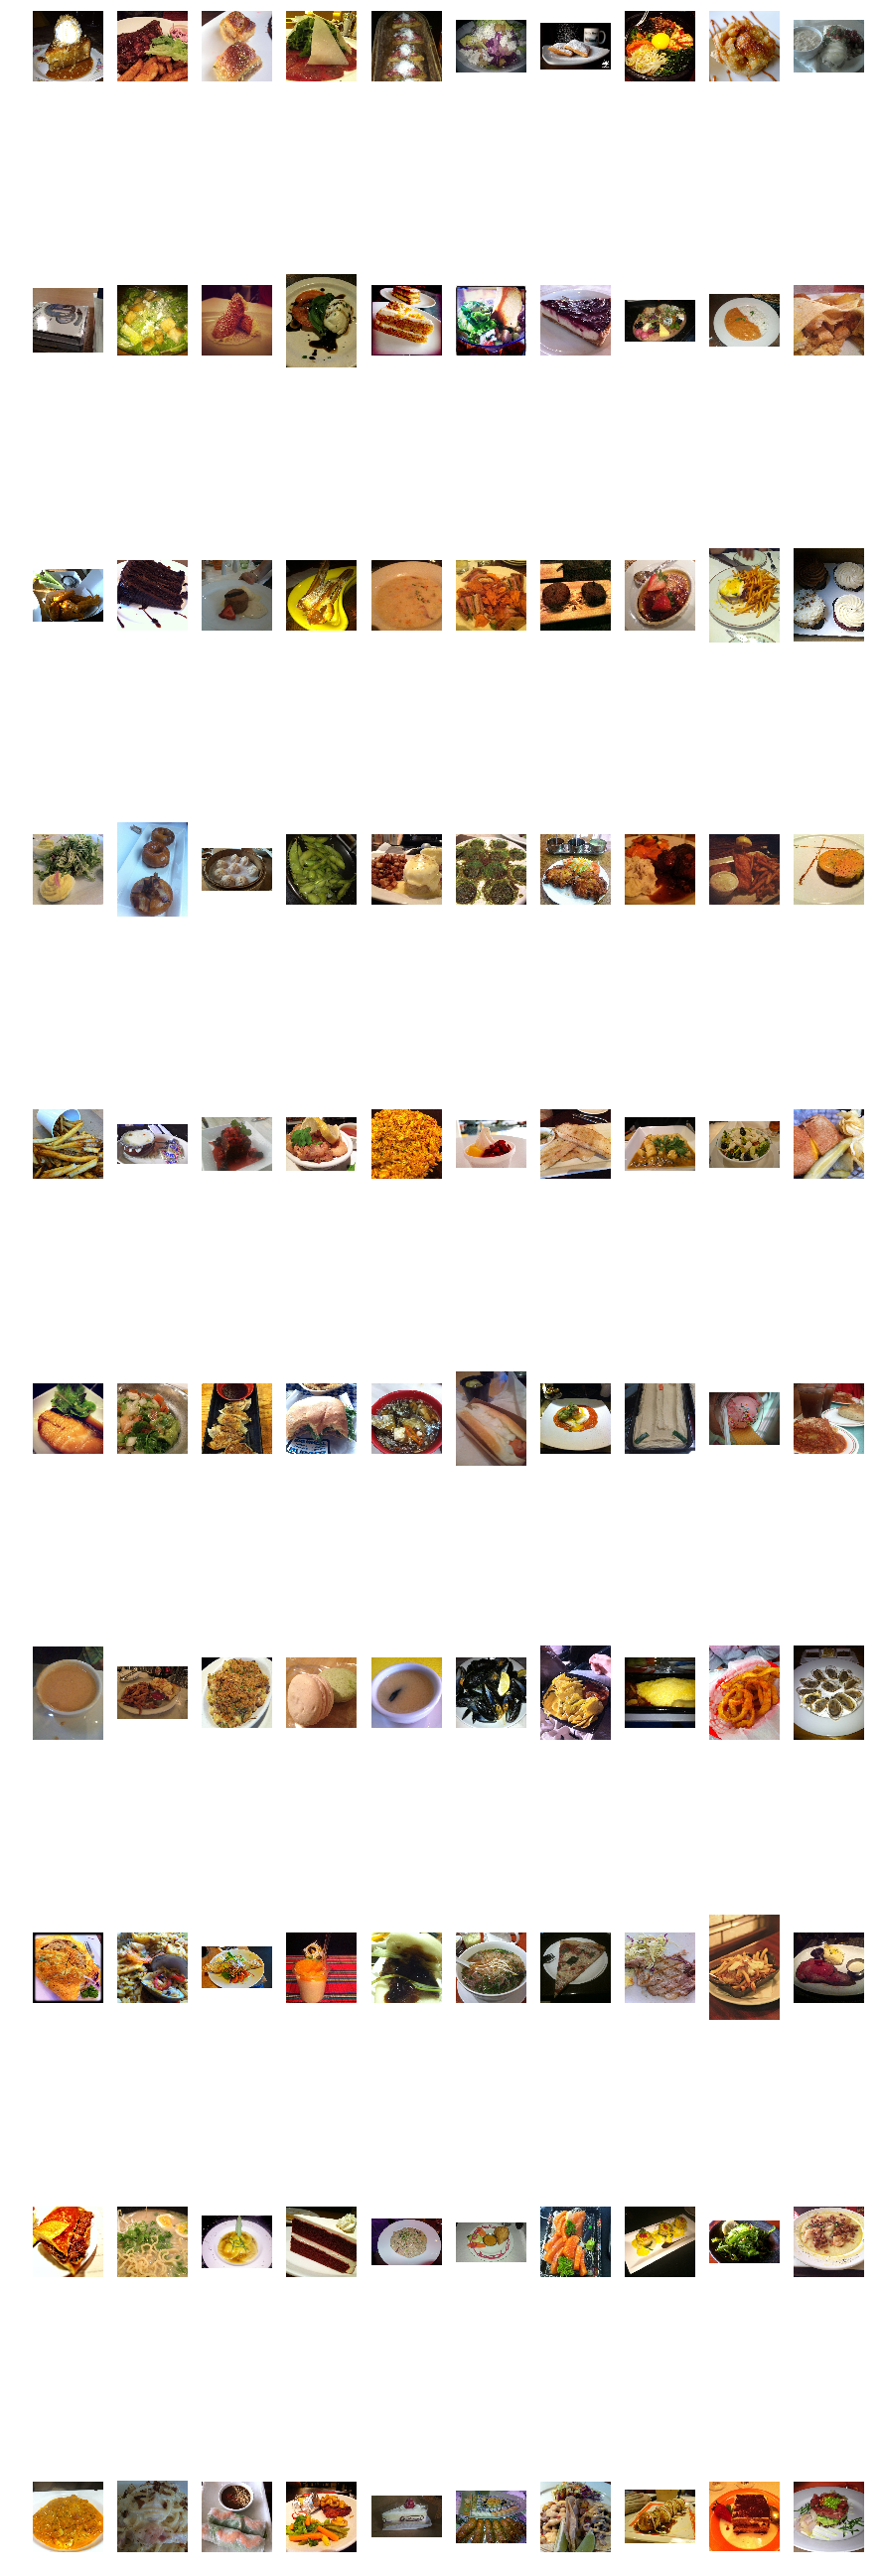

In [39]:
# plot a random img from each class
folders = !ls {PATH}valid
imgs = []
for folder in folders:
    files = !ls {PATH}valid/{folder} | head
    random_choice = random.choice(files)
    img = open_image(os.path.join(PATH, 'valid', folder, random_choice))
    imgs.append(img)
    
plots(imgs[:100], figsize=(15, 50), rows = 10)

In [ ]:
# If you need to reset your precomputed activations
!rm -rf {PATH}tmp

In [8]:
arch=resnext101
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[512, 512], ps=0.5)
# Uncomment to load trained model
learn.load('better_model')

In [ ]:
learn.fit(0.01, 30)
learn.fit(0.001, 30)
learn.fit(0.0001, 50)

# unfreeze frozen layers and train again
learn.unfreeze()
# learning rate dacays with deepness of layers
lr=np.array([1e-5,1e-4,1e-3])


learn.fit(lr, 20, cycle_len=1, cycle_mult=2)

In [ ]:
learn.save('better_model')

In [9]:
# print data classes
print(data.classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [10]:
# Prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(10100, 101)

In [13]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds)
print(preds)

[  0   2   2 ..., 100 100 100]


In [14]:
def topK(k):
    corrects = 0
    per_class = np.zeros(101)
    for i in range(len(probs)):
        c = int(i/100)
        if np.argmax(probs[i]) == c:
            per_class[c] += 1
        max_indexes = probs[i].argsort()[-k:][::-1]
        if c in max_indexes:
            corrects += 1
    print(corrects/10100)
    return per_class
 
per_class = topK(5)

0.9025742574257426


In [15]:
# top classes:
for i in range(len(per_class)):
    if per_class[i] > 80:
        print(per_class[i], data.classes[i])

81.0 beef_carpaccio
84.0 beignets
84.0 bibimbap
90.0 chicken_wings
85.0 churros
82.0 clam_chowder
88.0 creme_brulee
84.0 dumplings
98.0 edamame
82.0 eggs_benedict
84.0 fish_and_chips
83.0 french_fries
83.0 french_onion_soup
93.0 frozen_yogurt
83.0 guacamole
81.0 hamburger
90.0 hot_and_sour_soup
81.0 lobster_bisque
82.0 lobster_roll_sandwich
89.0 macarons
88.0 miso_soup
86.0 onion_rings
87.0 oysters
84.0 pad_thai
82.0 paella
82.0 peking_duck
88.0 pho
84.0 sashimi
89.0 seaweed_salad
85.0 spaghetti_bolognese
85.0 spaghetti_carbonara


In [16]:
# worst classes:
for i in range(len(per_class)):
    if per_class[i] < 50:
        print(per_class[i], data.classes[i])

49.0 apple_pie
41.0 chocolate_mousse
40.0 foie_gras
47.0 huevos_rancheros
45.0 ravioli
46.0 scallops
38.0 steak


In [17]:
# Data augmentation
tfms = tfms_from_model(resnext101, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [18]:
ims = np.stack([get_augs() for i in range(6)])

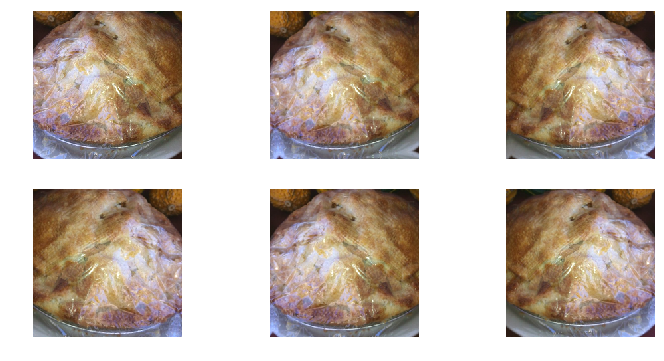

In [20]:
plots(ims, rows=2)

In [40]:
# Test time data augmentation
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [ ]:
accuracy(preds, y)